##### Importing Libraries 

In [94]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,MaxPooling2D,Conv2D,Flatten,Dropout
from keras.callbacks import EarlyStopping

#####  Import the dataset

In [95]:
df=pd.read_csv("driver_imgs_list.csv")

In [96]:
df.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [97]:
df.shape

(22424, 3)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


In [99]:
df["classname"].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64

<AxesSubplot:xlabel='classname', ylabel='count'>

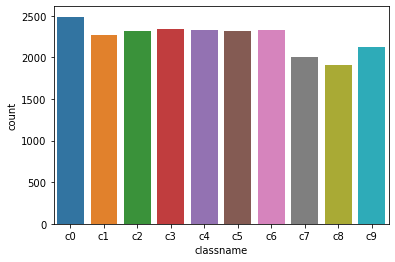

In [100]:
sns.countplot(df["classname"])

In [101]:
path="C:\\Users\\DELL\\Downloads\\state-farm-distracted-driver-detection\\imgs"

In [102]:
os.listdir(path)

['test', 'train']

In [104]:
train_path=path+"\\train\\"

In [105]:
os.listdir(train_path)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [107]:
classes = [c for c in os.listdir(train_path)]
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


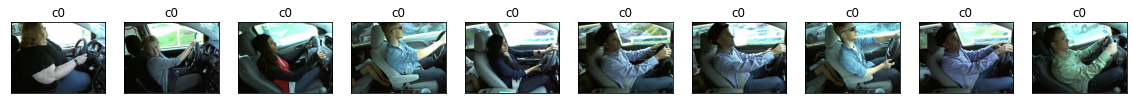

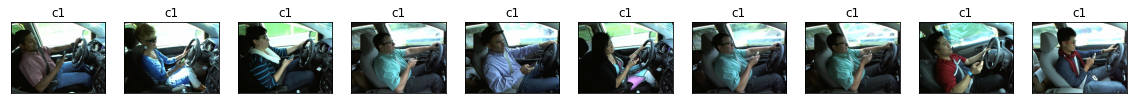

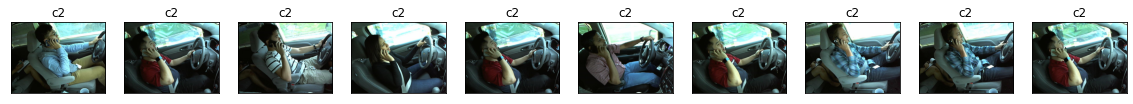

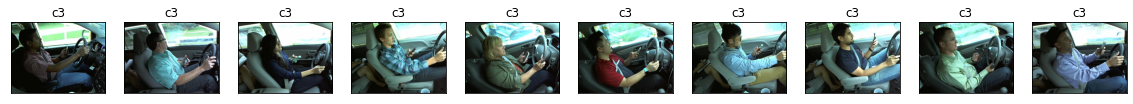

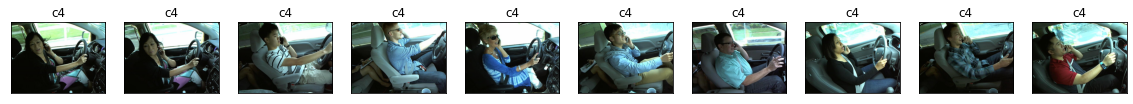

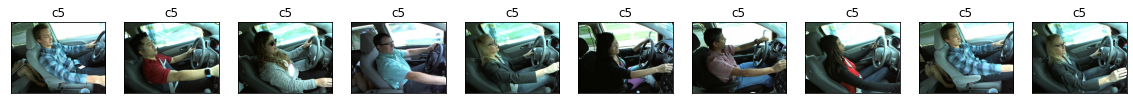

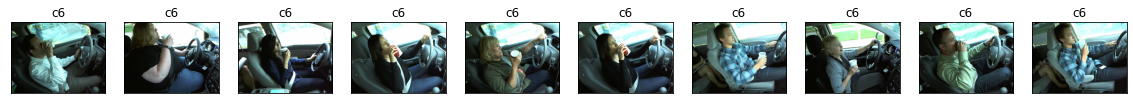

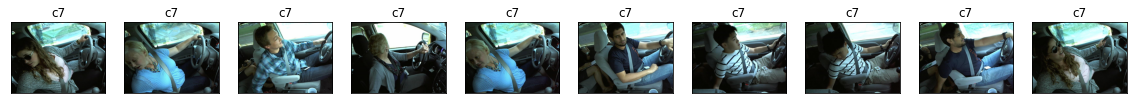

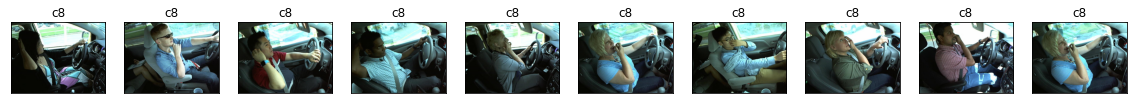

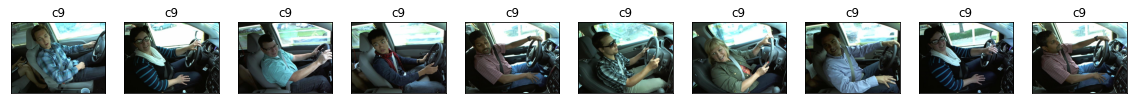

In [108]:
import random
for c in classes:

    fig=plt.figure(figsize=(20,20))
    cl = train_path + c
    for i,sample in enumerate(random.sample(os.listdir(train_path + c) , 10)):
        fig.add_subplot(10, 10, i+1)
        image = plt.imread(cl + '/' + sample)

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{c}")

In [109]:
classes_mapping = {   'c0' : "safe_driving",
                      'c1' : "texting-right",
                      'c2' : "talking_on_the_phone-right",
                      'c3' : "texting-left",
                      'c4' : "talking_on_the_phone-left",
                      'c5' : "operating_the_radio",
                      'c6' : "drinking",
                      'c7' : "reaching_behind",
                      'c8' : "hair-and-makeup",
                      'c9' : "talking_to_passenger"}

#### RESIZING IMAGES 

In [111]:
os.listdir(train_path+"c0\\")[0]

'img_100026.jpg'

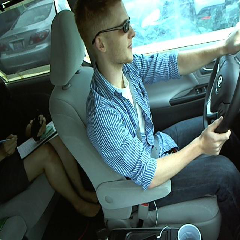

In [112]:
from tensorflow.keras.preprocessing import image
img = image.load_img('C:\\Users\\DELL\\Downloads\\state-farm-distracted-driver-detection\\imgs\\train\\c0\\img_100026.jpg', 
        target_size = (240, 240))
img

In [113]:
from tensorflow.keras.utils import img_to_array
img_arr=img_to_array(img)

In [114]:
img_arr.max(),img_arr.min()

(255.0, 0.0)

In [115]:
datagen=ImageDataGenerator(rescale=1/255.0,
                width_shift_range = 0.3,
                height_shift_range = 0.3,
                shear_range = 0.3,
                zoom_range = 0.4,
                validation_split = 0.2)

In [116]:
batch_size = 32
train_batches =datagen.flow_from_directory(directory = train_path,shuffle = True,batch_size = batch_size,target_size = (240, 240),subset = "training")
validation_batches =datagen.flow_from_directory(directory= train_path,shuffle = False,batch_size = 1,target_size = (240, 240),subset = "validation")

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


##### Building the mode 

In [117]:
model = Sequential()
model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (240, 240, 3), data_format = 'channels_last'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 10, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 238, 238, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 119, 119, 128)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 117, 117, 64)      73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 32)      

#### Train the model 

In [118]:
stop_criteria = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

In [122]:
import warnings
warnings.filterwarnings("ignore")
model.fit_generator(train_batches,validation_data=validation_batches,epochs = 10,callbacks=[stop_criteria])

Epoch 1/10
561/561 [==============================] - 2737s 5s/step - loss: 2.1824 - accuracy: 0.1746 - val_loss: 1.9677 - val_accuracy: 0.2636
Epoch 2/10
561/561 [==============================] - 2312s 4s/step - loss: 1.7755 - accuracy: 0.3299 - val_loss: 1.6088 - val_accuracy: 0.3937
Epoch 3/10
561/561 [==============================] - 2481s 4s/step - loss: 1.5255 - accuracy: 0.4313 - val_loss: 1.4313 - val_accuracy: 0.4682
Epoch 4/10
561/561 [==============================] - 3063s 5s/step - loss: 1.3280 - accuracy: 0.5152 - val_loss: 1.2731 - val_accuracy: 0.5432
Epoch 5/10
561/561 [==============================] - 2597s 5s/step - loss: 1.1538 - accuracy: 0.5889 - val_loss: 1.0384 - val_accuracy: 0.6425
Epoch 6/10
561/561 [==============================] - 2352s 4s/step - loss: 0.9967 - accuracy: 0.6448 - val_loss: 0.8989 - val_accuracy: 0.6882
Epoch 7/10
561/561 [==============================] - 2678s 5s/step - loss: 0.8736 - accuracy: 0.6944 - val_loss: 0.8583 - val_accuracy:

<AxesSubplot:>

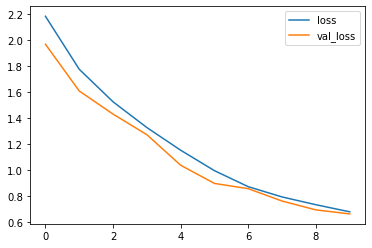

In [140]:
losses=pd.DataFrame(model.history.history)
losses[["loss","val_loss"]].plot()

<AxesSubplot:>

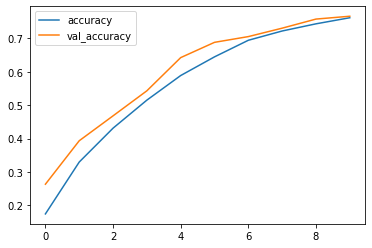

In [141]:
losses[["accuracy","val_accuracy"]].plot()

In [145]:
loss,accuracy=model.evaluate_generator(validation_batches)

In [146]:
print(accuracy*100)

77.37112045288086


In [147]:
t_path="C:\\Users\\DELL\\Downloads\\state-farm-distracted-driver-detection\\imgs"

In [148]:
tst_gen=ImageDataGenerator(1/255.0)
tst_data = tst_gen.flow_from_directory(t_path,
                                       target_size = (240, 240),
                                       batch_size = 128,
                                       classes = ['test'],
                                       shuffle = False)

Found 79726 images belonging to 1 classes.


In [149]:
predictions=model.predict(tst_data)

623/623 [==============================] - 3035s 5s/step


In [150]:
predictions.shape

(79726, 10)

In [151]:
test_output_prob = pd.DataFrame(predictions)

In [152]:
test_output_prob.columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [153]:
test_output_prob.head()

c0            c1   c2   c3   c4        c5            c6            c7  \
0  0.0  0.000000e+00  0.0  0.0  0.0  1.000000  0.000000e+00  0.000000e+00   
1  0.0  0.000000e+00  0.0  0.0  0.0  1.000000  0.000000e+00  0.000000e+00   
2  0.0  1.227452e-23  0.0  0.0  0.0  0.999916  9.280538e-32  2.090184e-10   
3  0.0  0.000000e+00  0.0  0.0  0.0  1.000000  0.000000e+00  0.000000e+00   
4  0.0  0.000000e+00  1.0  0.0  0.0  0.000000  0.000000e+00  0.000000e+00   

    c8   c9  
0  1.0  1.0  
1  1.0  1.0  
2  1.0  1.0  
3  1.0  1.0  
4  1.0  1.0

In [156]:
cls=np.argmax(predictions,axis=1)

In [161]:
predicted=[]
for i in cls:
    predicted.append((classes[i],classes_mapping[classes[i]]))
    print(classes[i],classes_mapping[classes[i]])

c5 operating_the_radio
c5 operating_the_radio
c8 hair-and-makeup
c5 operating_the_radio
c2 talking_on_the_phone-right
c7 reaching_behind
c5 operating_the_radio
c5 operating_the_radio
c2 talking_on_the_phone-right
c4 talking_on_the_phone-left
c2 talking_on_the_phone-right
c4 talking_on_the_phone-left
c2 talking_on_the_phone-right
c5 operating_the_radio
c2 talking_on_the_phone-right
c5 operating_the_radio
c5 operating_the_radio
c5 operating_the_radio
c2 talking_on_the_phone-right
c5 operating_the_radio
c2 talking_on_the_phone-right
c2 talking_on_the_phone-right
c2 talking_on_the_phone-right
c7 reaching_behind
c0 safe_driving
c0 safe_driving
c2 talking_on_the_phone-right
c2 talking_on_the_phone-right
c2 talking_on_the_phone-right
c5 operating_the_radio
c5 operating_the_radio
c5 operating_the_radio
c5 operating_the_radio
c0 safe_driving
c1 texting-right
c5 operating_the_radio
c2 talking_on_the_phone-right
c0 safe_driving
c2 talking_on_the_phone-right
c2 talking_on_the_phone-right
c2 talkin